In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



df_train = pd.read_csv('illinois_basing_train.csv')
df_train.drop('Avg_PLT_CO2InjRate_TPH', axis=1, inplace = True)
df_test = pd.read_csv('illinois_basing_test.csv')

df_train[df_train.columns[-1]].fillna(0, inplace = True)
y = df_train[df_train.columns[-1]]
df_train.drop(df_train.columns[-1], axis=1, inplace = True)

df_train['Month'] = pd.to_datetime(df_train['SampleTimeUTC']).dt.month
df_train['Day'] = pd.to_datetime(df_train['SampleTimeUTC']).dt.day
df_train['Hour'] = pd.to_datetime(df_train['SampleTimeUTC']).dt.hour
df_train['Year'] = pd.DatetimeIndex(df_train['SampleTimeUTC']).year
df_train.drop('SampleTimeUTC', axis=1, inplace = True)


df_test['Month'] = pd.to_datetime(df_test['SampleTimeUTC']).dt.month
df_test['Day'] = pd.to_datetime(df_test['SampleTimeUTC']).dt.day
df_test['Hour'] = pd.to_datetime(df_test['SampleTimeUTC']).dt.hour
df_test['Year'] = pd.DatetimeIndex(df_test['SampleTimeUTC']).year
df_test.drop('SampleTimeUTC', axis=1, inplace = True)

cols = [i for i in df_train.columns if df_train[i].isnull().any()]
for i in cols:
    df_train[i].fillna(df_train[i].mean(), inplace=True)

cols = [i for i in df_test.columns if df_test[i].isnull().any()]
for i in cols:
    df_test[i].fillna(df_test[i].mean(), inplace=True)
    

    
X_train, X_val, y_train, y_val = train_test_split(
    df_train, y, test_size=0.1, random_state=13
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(df_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test = np.array(X_test)


In [5]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data = None):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float())

In [6]:
EPOCHS = 15
BATCH_SIZE = 1
LEARNING_RATE = 0.007
NUM_FEATURES = len(df_train.columns)

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [8]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 8)
        self.layer_3 = nn.Linear(8, 4)
        self.layer_out = nn.Linear(4, 1)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=37, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
loss_stats = {
    'train': [],
    "val": []
}

In [12]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()    
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)      
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_epoch_loss += val_loss.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
            loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 7595.58550 | Val Loss: 13.57957
Epoch 002: | Train Loss: 7595.36701 | Val Loss: 13.56498
Epoch 003: | Train Loss: 7595.48772 | Val Loss: 13.66808
Epoch 004: | Train Loss: 7595.14093 | Val Loss: 13.55988
Epoch 005: | Train Loss: 7595.61265 | Val Loss: 13.55850
Epoch 006: | Train Loss: 7595.36792 | Val Loss: 13.65354
Epoch 007: | Train Loss: 7595.65472 | Val Loss: 13.56477
Epoch 008: | Train Loss: 7595.41564 | Val Loss: 13.56135
Epoch 009: | Train Loss: 7595.57206 | Val Loss: 13.72198
Epoch 010: | Train Loss: 7595.34647 | Val Loss: 13.57066
Epoch 011: | Train Loss: 7595.51623 | Val Loss: 13.58922
Epoch 012: | Train Loss: 7595.38718 | Val Loss: 13.56162
Epoch 013: | Train Loss: 7595.49092 | Val Loss: 13.61709
Epoch 014: | Train Loss: 7595.59516 | Val Loss: 13.69689
Epoch 015: | Train Loss: 7595.46055 | Val Loss: 13.57025


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

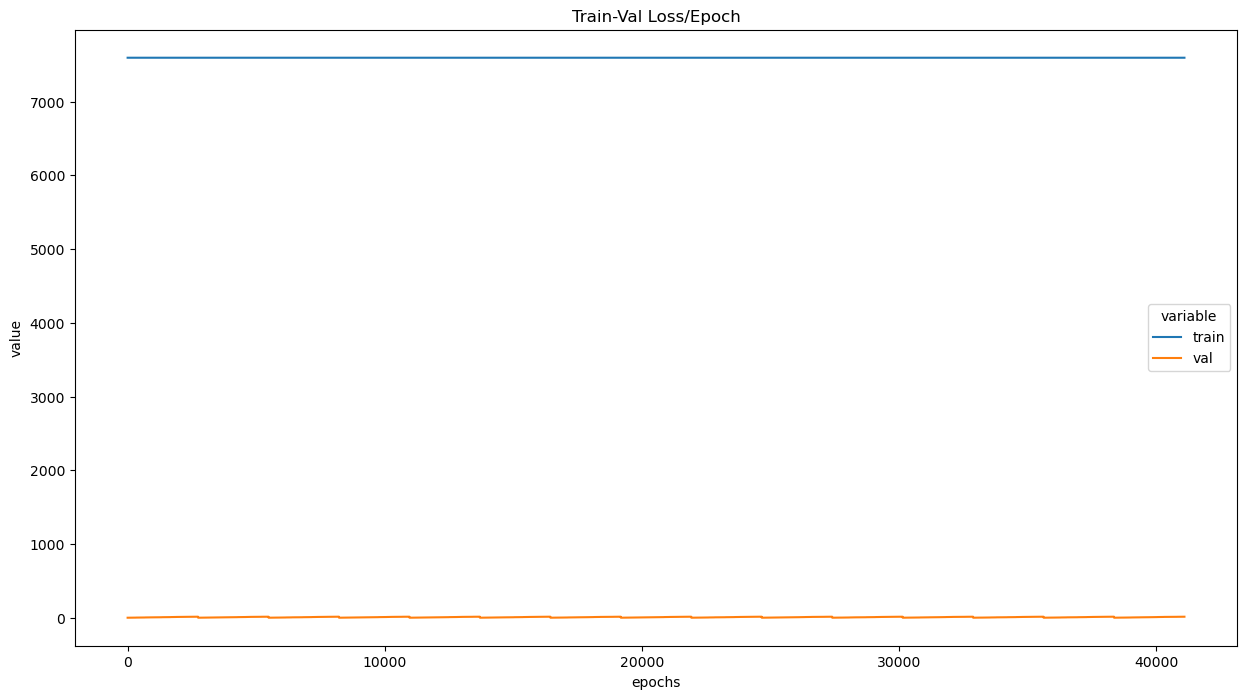

In [13]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [14]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)